### Load Documents with ID

In [8]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [9]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

### Load ground truth

In [10]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [11]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [12]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Index data

In [13]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [14]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [15]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|██████████| 948/948 [00:59<00:00, 16.02it/s]


### Retrieval

In [16]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [17]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

### The RAG flow

In [18]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION. 
Also dont say or give the context just answer the question but dont be brief.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [19]:
# import libraries
from groq import Groq
from dotenv import load_dotenv
import os

# load environment variables
load_dotenv()

# create client calling Groq class
client = Groq(api_key=os.getenv('GROQ_API_KEY'))

def llm(prompt, model="llama3-8b-8192"):
    # create a query
    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model,
    )
    # print the response
    return response.choices[0].message.content

In [20]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama-3.1-8b-instant') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [21]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [22]:
rag(ground_truth[10])

"Yes, sessions are recorded, so if you miss one, you won't miss anything. Specifically, everything, including the occasional live office hours sessions, is recorded. This includes the pre-recorded course videos as well as the office hours sessions. You can always catch up on the recorded sessions, and of course, you can also reach out to me ahead of time for office hours questions. Additionally, you can always ask questions in Slack."

In [23]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Cosine similarity metric

In [24]:
answer_orig = "Yes, sessions are recorded, so you won't miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack, as mentioned in the FAQ."
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.82837373

In [25]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [26]:
len(ground_truth)

1830

In [27]:
# answers = {}

In [28]:
# for i, rec in enumerate(tqdm(ground_truth)):
#     if i in answers:
#         continue

#     answer_llm = rag(rec)
#     doc_id = rec['document']
#     original_doc = doc_idx[doc_id]
#     answer_orig = original_doc['text']

#     answers[i] = {
#         'answer_llm': answer_llm,
#         'answer_orig': answer_orig,
#         'document': doc_id,
#         'question': rec['question'],
#         'course': rec['course'],
#     }

In [29]:
# results_gpt4o = [None] * len(ground_truth)

# for i, val in answers.items():
#     results_gpt4o[i] = val.copy()
#     results_gpt4o[i].update(ground_truth[i

In [30]:
import pandas as pd

In [31]:
# df_gpt4o = pd.DataFrame(results_gpt4o)

In [32]:
# df_gpt4o.to_csv('data/results-llama-31.csv', index=False)

### Using parallelization

In [33]:
# rag(ground_truth[10], model="gemma-7b-it")

In [34]:
# from concurrent.futures import ThreadPoolExecutor

# pool = ThreadPoolExecutor(max_workers=3)

# def map_progress(pool, seq, f):
#     results = []

#     with tqdm(total=len(seq)) as progress:
#         futures = []

#         for el in seq:
#             future = pool.submit(f, el)
#             future.add_done_callback(lambda p: progress.update())
#             futures.append(future)

#         for future in futures:
#             result = future.result()
#             results.append(result)

#     return results

In [35]:
# def process_record(rec):
#     model = 'gemma-7b-it'
#     answer_llm = rag(rec, model=model)
    
#     doc_id = rec['document']
#     original_doc = doc_idx[doc_id]
#     answer_orig = original_doc['text']

#     return {
#         'answer_llm': answer_llm,
#         'answer_orig': answer_orig,
#         'document': doc_id,
#         'question': rec['question'],
#         'course': rec['course'],
#     }

In [36]:
# process_record(ground_truth[10])

In [37]:
# results_gemma_7b = map_progress(pool, ground_truth, process_record)

In [38]:
# df_gemma7b = pd.DataFrame(results_gemma_7b)
# df_gemma7b.to_csv('data/results-gemma-7b.csv', index=False)

### Cosine Similarity
##### GPT 4o

In [39]:
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')
df_gpt35 = pd.read_csv('data/results-gpt35.csv')
df_gpt4m = pd.read_csv('data/results-gpt4o-mini.csv')

In [40]:
results_gpt4o = df_gpt4o.to_dict(orient='records')
results_gpt35 = df_gpt35.to_dict(orient='records')
results_gpt4m = df_gpt4m.to_dict(orient='records')

In [41]:
record = results_gpt4o[0]

In [42]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [43]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1830/1830 [01:46<00:00, 17.22it/s]


In [44]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

### Cosine Similarity
##### GPT 3.5 Turbo

In [45]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

100%|██████████| 1830/1830 [01:25<00:00, 21.36it/s]


In [46]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

### Cosine Similarity
##### GPT 4o Mini

In [47]:
results_gpt4m = df_gpt4m.to_dict(orient='records')

similarity_4m = []

for record in tqdm(results_gpt4m):
    sim = compute_similarity(record)
    similarity_4m.append(sim)

100%|██████████| 1830/1830 [01:33<00:00, 19.67it/s]


In [48]:
df_gpt4m['cosine'] = similarity_4m
df_gpt4m['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

### Comparision of the models

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

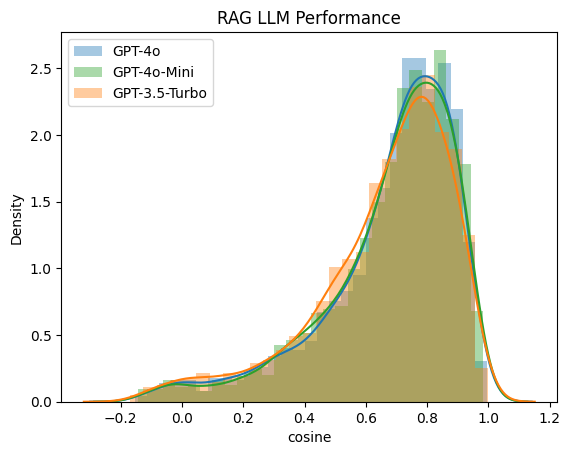

In [50]:
# Hide the deprecated and user warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot KDEs with adjusted transparency, different line styles, and custom colors
sns.distplot(df_gpt4o['cosine'], label='GPT-4o', color=colors[0])
sns.distplot(df_gpt4m['cosine'], label='GPT-4o-Mini', color=colors[2])
sns.distplot(df_gpt35['cosine'], label='GPT-3.5-Turbo', color=colors[1])

# Display the legend
plt.legend()
plt.title('RAG LLM Performance')

# Show the plot
plt.show()


### LLM as a Judge

In [51]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [53]:
df_sample = df_gpt4m.sample(n=150, random_state=1)

In [54]:
samples = df_sample.to_dict(orient='records')

In [55]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.901075541973114}

In [56]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [57]:
answer = llm(prompt, model='llama3-groq-8b-8192-tool-use-preview')

In [58]:
import json

In [59]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='llama3-groq-8b-8192-tool-use-preview')
    evaluations.append(evaluation)

100%|██████████| 150/150 [04:46<00:00,  1.91s/it]


In [60]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [61]:
df_evaluations = pd.DataFrame(json_evaluations)

In [62]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           121
PARTLY_RELEVANT     15
NON_RELEVANT        14
Name: count, dtype: int64

In [67]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer does not address the spec...
11,NON_RELEVANT,The generated answer addresses a different iss...
27,NON_RELEVANT,The generated answer does not address the ques...
41,NON_RELEVANT,The generated answer is about setting up a Con...
45,NON_RELEVANT,The generated answer does not address the spec...
49,NON_RELEVANT,The generated answer does not address the spec...
69,NON_RELEVANT,The generated answer does not directly address...
71,NON_RELEVANT,The generated answer does not address the orig...
81,NON_RELEVANT,The generated answer does not address the main...
87,NON_RELEVANT,The generated answer does not address the orig...


In [65]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

In [68]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What modification was made to the median_house_value target in the homework?
Generated Answer: The modification made to the `median_house_value` target in the homework was that it was changed to binary format. The values were made discrete as either 0 or 1, instead of remaining as a continuous variable. This change was necessary for the calculation of the mutual information score, which is applicable to categorical or discrete variables rather than continuous ones.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | 

In [69]:
evaluation = llm(prompt, model='llama3-groq-8b-8192-tool-use-preview')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the modification made to the median_house_value target in the homework, providing details on how it was changed to a binary format for the calculation of the mutual information score."
}


In [71]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='llama3-groq-8b-8192-tool-use-preview')
    evaluations_2.append(evaluation)

100%|██████████| 150/150 [04:41<00:00,  1.87s/it]


In [72]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [73]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [74]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
27,NON_RELEVANT,The generated answer does not address the ques...
29,NON_RELEVANT,The generated answer does not directly address...
45,NON_RELEVANT,The generated answer does not address the spec...
49,NON_RELEVANT,The generated answer does not address the ques...
64,NON_RELEVANT,The generated answer does not address the ques...
85,NON_RELEVANT,The generated answer does not address the ques...
93,NON_RELEVANT,The generated answer does not directly address...
139,NON_RELEVANT,The generated answer does not address the ques...


In [75]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.5113019943237305}

### Saving Data